Rose Eluvathingal Muttikkal (re4mfy)

In [1]:
%load_ext autoreload
%autoreload 2

# Load Packages

In [2]:
#!pip install torchinfo

In [3]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

import torch

from torch import manual_seed as torch_manual_seed
import random
import numpy as np

from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn


In [4]:
#!pip install torchvision 

In [5]:
from sklearn.datasets import load_files
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import Generator
from torchvision.datasets import ImageFolder
from torchvision.transforms.functional import to_pil_image

In [6]:
from torch.nn import Module
from torch import nn
from torchinfo import summary
import pandas as pd
from numpy import mean

In [7]:
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler

In [8]:
gpu_info = !nvidia-smi
gpu_info = 'n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Apr 18 12:38:34 2024       n+---------------------------------------------------------------------------------------+n| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |n|-----------------------------------------+----------------------+----------------------+n| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |n| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |n|                                         |                      |               MIG M. |n|=========================================+======================+======================|n|   0  NVIDIA RTX A6000               Off | 00000000:C1:00.0 Off |                  Off |n| 30%   31C    P8              20W / 300W |     16MiB / 49140MiB |      0%      Default |n|                                         |                      |                  N/A |n+-----------------------------------------+----------------------+--

# Random Seed for Reproduction

In [9]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

# Helper Functions

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  losses_train = []
  accuracies_epoch = []
  for batch, (X, y) in enumerate(dataloader):
    # Compute prediction and loss
    X = X.to(device)
    y = y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 20 == 0:
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    losses_train.append(loss)

    with torch.no_grad():
      accuracy_batch = (pred.argmax(1) == y).type(torch.float).sum().item()/len(y)
      accuracies_epoch.append(accuracy_batch)
  return losses_train, accuracies_epoch

def test_loop(dataloader, model, loss_fn, method="Test"):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"{method} Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

  return test_loss, correct

def train(model, num_epochs, loss_function, optimizer, dataloader_train, dataloader_valid):
    losses_train_all_epochs = []
    accuracies_train_all_epochs = []
    accuracies_val_all_epochs = []
    losses_val_all_epochs = []

    for t in range(num_epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        losses_train, accuracies_epoch = train_loop(dataloader_train, model, loss_function, optimizer)
        losses_train_all_epochs.append(losses_train)
        accuracies_train_all_epochs.append(accuracies_epoch)

        accuracy_val, loss_val = test_loop(dataloader_valid, model, loss_function, method="Valid")
        accuracies_val_all_epochs.append(accuracy_val)
        losses_val_all_epochs.append(loss_val)
    print("Done!")
    return accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs

In [12]:
def to_numpy(tensor):
    if isinstance(tensor, (int, float)):
        return tensor
    elif isinstance(tensor, torch.Tensor):
        return tensor.cpu().detach().numpy()
    elif isinstance(tensor, list):
        return [to_numpy(item) for item in tensor]
    else:
        raise ValueError("Unsupported type")

def plot_history(accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs, method='mean'):
    if method == 'mean':
        accuracies_train = [mean(accuracies_train_per_epoch) for accuracies_train_per_epoch in accuracies_train_all_epochs]
        losses_train = [mean(losses_train_per_epoch) for losses_train_per_epoch in losses_train_all_epochs]
    elif method == 'end':
        accuracies_train = [accuracies_train_per_epoch[-1] for accuracies_train_per_epoch in accuracies_train_all_epochs]
        losses_train = [losses_train_per_epoch[-1] for losses_train_per_epoch in losses_train_all_epochs]

    df_runs = pd.DataFrame({
        'accuracy_train': accuracies_train,
        'accuracy_valid': accuracies_val_all_epochs,
        'loss_train': to_numpy(losses_train),
        'loss_valid': losses_val_all_epochs,
    })

    df_runs.plot(figsize=(14, 10))
    plt.grid(True)
    #plt.gca().set_ylim(0, 1)
    plt.show()

# It's your turn: Building a classifier for UVA Landmark Dataset
You may design your own architecture AND re-use any of the exising frameworks.

Best of luck!

## Pre-trained model implementation: ConvNext

### Data Import + Pre-Processing



In [13]:
TEST_RATIO = 0.2
BATCH_SIZE = 32

data_transforms = transforms.Compose(
    [   transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

data_dir = "train/"
data_dir_test = "test/"
# Download and load the training data
dataset_all = ImageFolder(
    data_dir,
    transform=data_transforms
)
dataset_test = ImageFolder(
    data_dir_test,
    transform=data_transforms
)

In [14]:
def find_classes(data_dir):
    classes = os.listdir(data_dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

In [15]:
classes, class_to_idx = find_classes(data_dir)
print(classes)

['FAKE', 'REAL']


In [16]:
classes, class_to_idx = find_classes(data_dir_test)
print(classes)

['FAKE', 'REAL']


In [17]:
size_all = len(dataset_all)
print(f'Before splitting the full dataset into train and test: len(dataset_all)={size_all}')

size_test = int(size_all * TEST_RATIO)
size_train = size_all - size_test

dataset_train, dataset_valid = random_split(dataset_all, [size_train, size_test], generator=Generator().manual_seed(SEED))
print(f'After splitting the full dataset into train and valid: len(dataset_train)={len(dataset_train)}. len(dataset_valid)={len(dataset_valid)}')

#load train, validation, and test set
train_dl = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

print(f'The dataset: len(dataset_tran)={len(dataset_train)}. len(dataset_valid)={len(dataset_valid)}. len(dataset_test)={len(dataset_test)}')

Before splitting the full dataset into train and test: len(dataset_all)=100000
After splitting the full dataset into train and valid: len(dataset_train)=80000. len(dataset_valid)=20000
The dataset: len(dataset_tran)=80000. len(dataset_valid)=20000. len(dataset_test)=20002


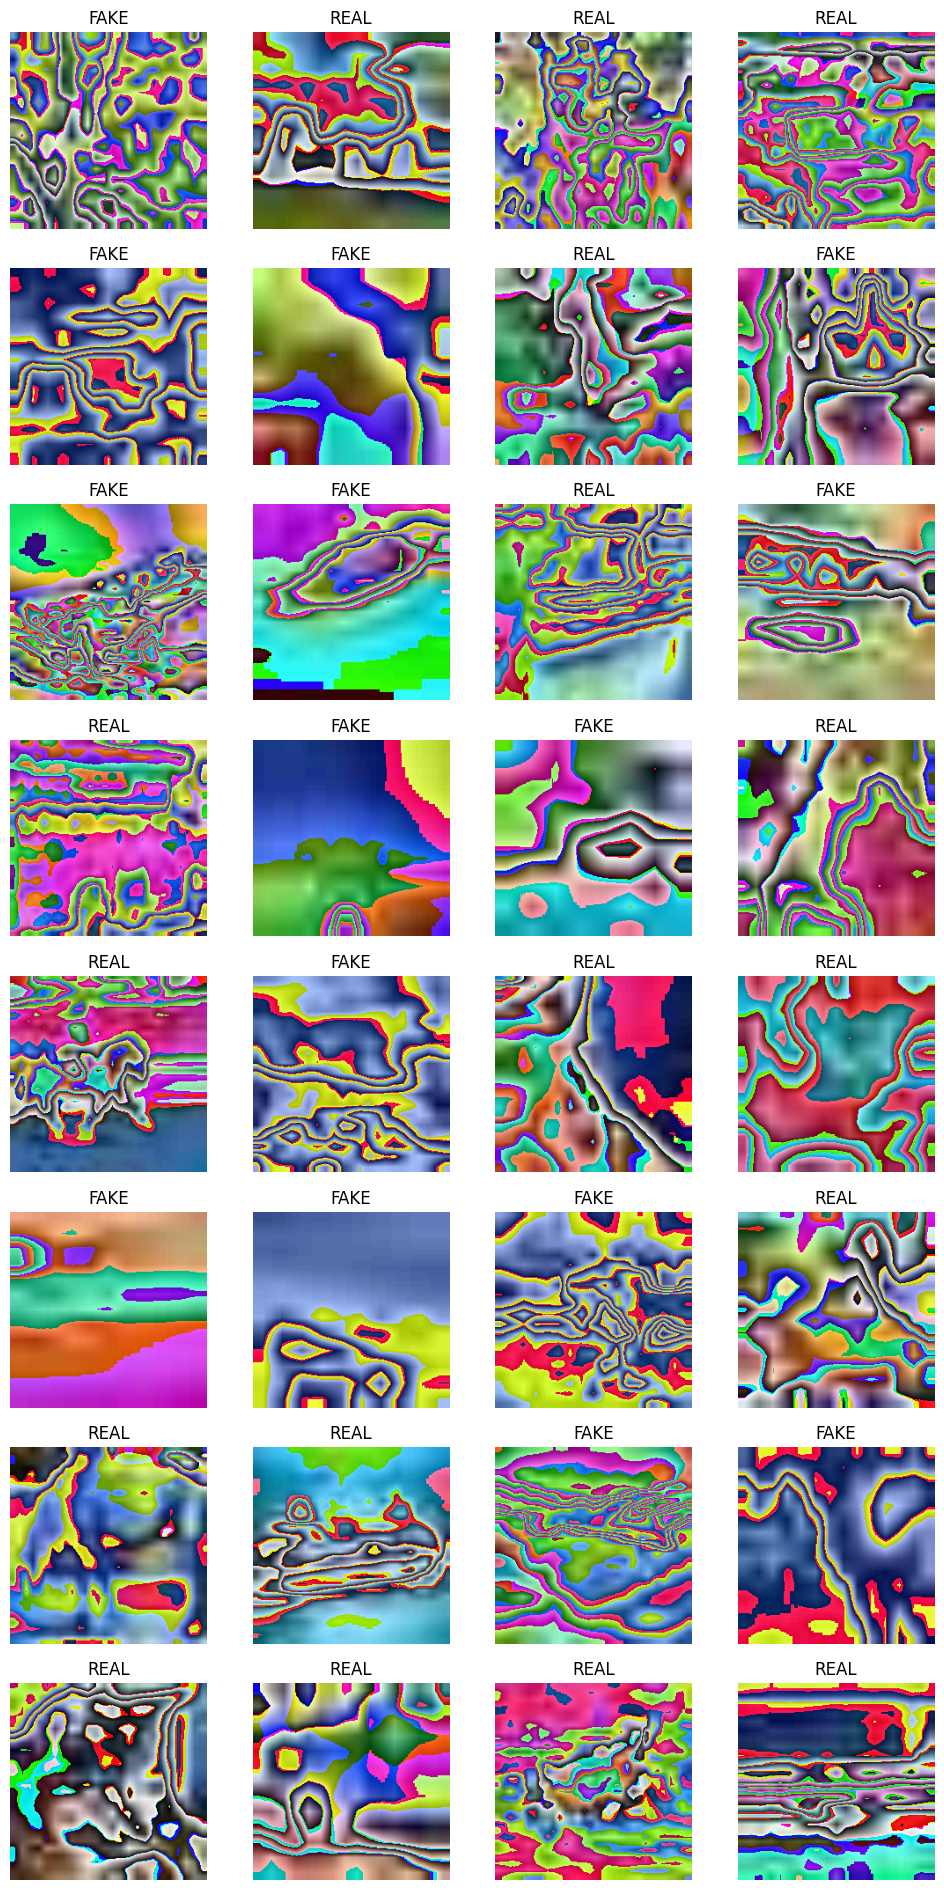

In [18]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['FAKE', 'REAL']

# Rows and columns are set to fit one training batch (32)

n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, target = dataset_train[index]
        plt.imshow(to_pil_image(image))
        plt.axis('off')
        plt.title(class_names[target], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

plt.show()

In [19]:
#image info
image_0, target_0 = dataset_train[0]
print(f'image_0.dtype = {image_0.dtype}')
print(f'image_0.size() = {image_0.size()}')
print(f'target_0 = {target_0}')
print(f'type(target_0) = {type(target_0)}')

image_0.dtype = torch.float32
image_0.size() = torch.Size([3, 224, 224])
target_0 = 0
type(target_0) = <class 'int'>


In [20]:
len(class_names)

2

### ***ConvNeXT***

In [21]:
model_conv = models.convnext_tiny(weights='DEFAULT', pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_conv.classifier[2] = torch.nn.Linear(
    in_features=model_conv.classifier[2].in_features,
    out_features=len(class_names)
)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = torch.optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_conv, 'min')

In [22]:
print(model_conv)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [23]:
from torchinfo import summary

In [29]:
summary(model_conv)

Layer (type:depth-idx)                        Param #
ConvNeXt                                      --
├─Sequential: 1-1                             --
│    └─Conv2dNormActivation: 2-1              --
│    │    └─Conv2d: 3-1                       (4,704)
│    │    └─LayerNorm2d: 3-2                  (192)
│    └─Sequential: 2-2                        --
│    │    └─CNBlock: 3-3                      (79,296)
│    │    └─CNBlock: 3-4                      (79,296)
│    │    └─CNBlock: 3-5                      (79,296)
│    └─Sequential: 2-3                        --
│    │    └─LayerNorm2d: 3-6                  (192)
│    │    └─Conv2d: 3-7                       (73,920)
│    └─Sequential: 2-4                        --
│    │    └─CNBlock: 3-8                      (306,048)
│    │    └─CNBlock: 3-9                      (306,048)
│    │    └─CNBlock: 3-10                     (306,048)
│    └─Sequential: 2-5                        --
│    │    └─LayerNorm2d: 3-11                 (384)
│    

In [25]:
import time

In [26]:
NUM_EPOCHS = 3
start = time.time()
accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs = train(model_conv, NUM_EPOCHS, criterion, optimizer_conv, train_dl, valid_dl)
end = time.time()
print("time elapsed: ", end-start) 

Epoch 1
-------------------------------
loss: 0.705664  [   32/80000]
loss: 0.620225  [  672/80000]
loss: 0.653669  [ 1312/80000]
loss: 0.497860  [ 1952/80000]
loss: 0.571929  [ 2592/80000]
loss: 0.507831  [ 3232/80000]
loss: 0.417231  [ 3872/80000]
loss: 0.514034  [ 4512/80000]
loss: 0.507994  [ 5152/80000]
loss: 0.482768  [ 5792/80000]
loss: 0.505229  [ 6432/80000]
loss: 0.639505  [ 7072/80000]
loss: 0.401258  [ 7712/80000]
loss: 0.386321  [ 8352/80000]
loss: 0.395946  [ 8992/80000]
loss: 0.473847  [ 9632/80000]
loss: 0.477834  [10272/80000]
loss: 0.541631  [10912/80000]
loss: 0.384953  [11552/80000]
loss: 0.599224  [12192/80000]
loss: 0.406561  [12832/80000]
loss: 0.510846  [13472/80000]
loss: 0.516273  [14112/80000]
loss: 0.566887  [14752/80000]
loss: 0.448579  [15392/80000]
loss: 0.519428  [16032/80000]
loss: 0.449388  [16672/80000]
loss: 0.476366  [17312/80000]
loss: 0.373974  [17952/80000]
loss: 0.382168  [18592/80000]
loss: 0.373970  [19232/80000]
loss: 0.497336  [19872/80000]


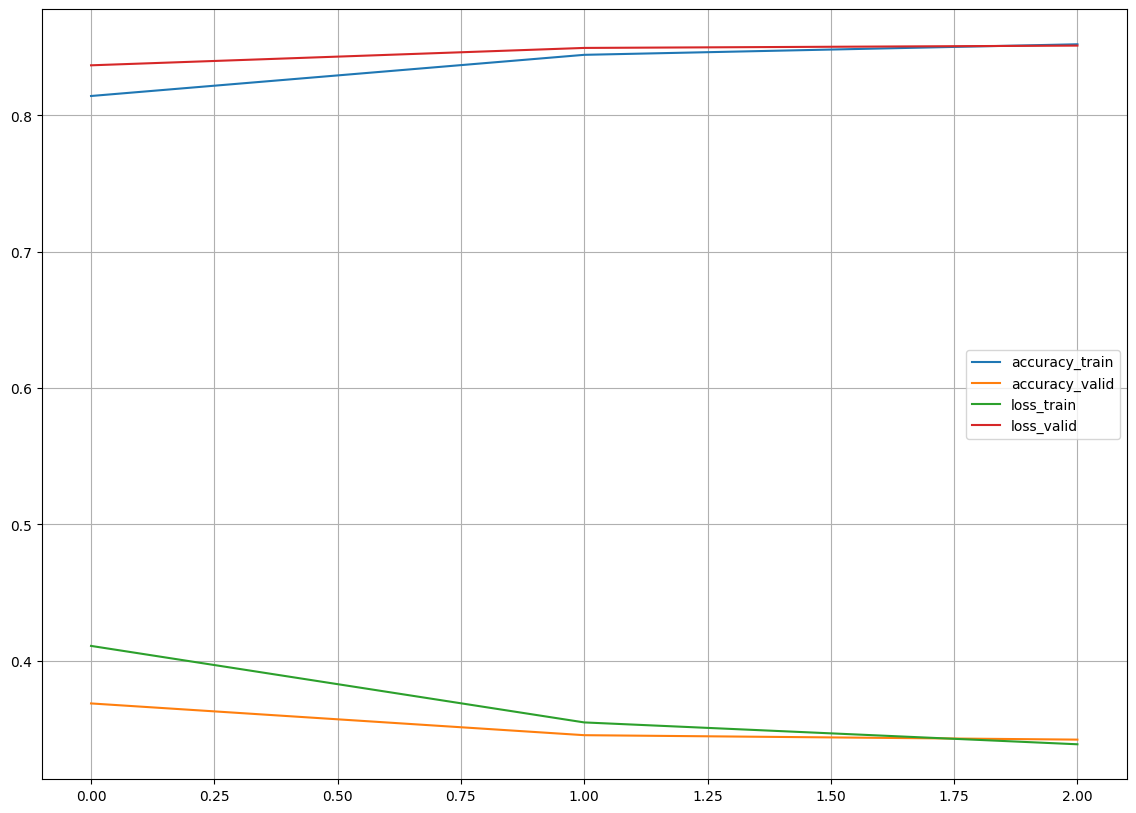

In [27]:
plot_history(accuracies_train_all_epochs, accuracies_val_all_epochs, to_numpy(losses_train_all_epochs), losses_val_all_epochs)

In [28]:
accuracy_test, loss_test = test_loop(test_dl, model_conv, criterion, method="Test")

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.340493 



In [30]:
# Save the model
torch.save(model_conv.state_dict(), 'convNEXT_model.pth')